In [10]:
!gdown 1-EUuljtwZ2aO2lPj5oqWSiAp-1WGdrKY
!unzip ashrae-energy-prediction.zip

# directory = '\Desktop\QUERA\Exercises\3rd_week\ashrae-energy-prediction'

Downloading...
From (original): https://drive.google.com/uc?id=1-EUuljtwZ2aO2lPj5oqWSiAp-1WGdrKY
From (redirected): https://drive.google.com/uc?id=1-EUuljtwZ2aO2lPj5oqWSiAp-1WGdrKY&confirm=t&uuid=db6cdb35-d28c-4e4b-831f-55dff8819860
To: /content/ashrae-energy-prediction.zip
100% 397M/397M [00:01<00:00, 233MB/s]
Archive:  ashrae-energy-prediction.zip
replace building_metadata.csv? [y]es, [n]o, [A]ll, [N]one, [r]ename: A
  inflating: building_metadata.csv   
  inflating: sample_submission.csv   
  inflating: test.csv                
  inflating: train.csv               
  inflating: weather_test.csv        
  inflating: weather_train.csv       


In [11]:
import pandas as pd
import numpy as np
import missingno as msno
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder, StandardScaler, PowerTransformer
from sklearn.tree import DecisionTreeRegressor
from sklearn.metrics import r2_score

In [12]:
train = pd.read_csv('train.csv')
weather_train = pd.read_csv('weather_train.csv')
building_metadata = pd.read_csv('building_metadata.csv')

# Merge tables
train = train.merge(building_metadata, on='building_id', how='left')
train = train.merge(weather_train, on=['site_id', 'timestamp'], how='left')

In [13]:
# Filtering meter column
train = train[train['meter'] == 0]
train = train.drop(columns=['meter'])

# Unit convert from kBTU to kWh for site_id 0
train.loc[train['site_id'] == 0, 'meter_reading'] *= 0.2931

In [14]:
train.describe()

,building_id,meter_reading,site_id,square_feet,year_built,floor_count,air_temperature,cloud_coverage,dew_temperature,precip_depth_1_hr,sea_level_pressure,wind_direction,wind_speed
count,1.206091e+07,1.206091e+07,1.206091e+07,1.206091e+07,5.590875e+06,2.964827e+06,1.201358e+07,6.731258e+06,1.201182e+07,9.547231e+06,1.104253e+07,1.138220e+07,1.199412e+07
mean,7.066480e+02,1.587643e+02,6.749956e+00,9.271431e+04,1.968335e+03,3.798080e+00,1.600965e+01,2.284164e+00,8.334990e+00,8.015276e-01,1.016408e+03,1.763599e+02,3.559324e+00
std,4.152330e+02,3.683867e+02,4.946888e+00,1.121100e+05,3.101556e+01,3.367543e+00,1.039774e+01,2.553476e+00,9.836796e+00,7.718845e+00,7.035792e+00,1.128772e+02,2.317835e+00
min,0.000000e+00,0.000000e+00,0.000000e+00,2.830000e+02,1.900000e+03,1.000000e+00,-2.890000e+01,0.000000e+00,-3.500000e+01,-1.000000e+00,9.682000e+02,0.000000e+00,0.000000e+00
25%,3.450000e+02,1.895000e+01,3.000000e+00,2.301200e+04,1.950000e+03,1.000000e+00,8.900000e+00,0.000000e+00,1.100000e+00,0.000000e+00,1.012100e+03,8.000000e+01,2.100000e+00
50%,6.980000e+02,5.937737e+01,5.000000e+00,5.781100e+04,1.970000e+03,3.000000e+00,1.670000e+01,2.000000e+00,9.400000e+00,0.000000e+00,1.016500e+03,1.800000e+02,3.100000e+00
75%,1.063000e+03,1.562500e+02,1.200000e+01,1.161210e+05,1.996000e+03,5.000000e+00,2.390000e+01,4.000000e+00,1.610000e+01,0.000000e+00,1.020700e+03,2.800000e+02,4.600000e+00
max,1.448000e+03,7.976900e+04,1.500000e+01,8.750000e+05,2.017000e+03,2.600000e+01,4.720000e+01,9.000000e+00,2.610000e+01,3.430000e+02,1.045500e+03,3.600000e+02,1.900000e+01


In [15]:
train.info()

<class 'pandas.core.frame.DataFrame'>
Index: 12060910 entries, 0 to 20216099
Data columns (total 15 columns):
 #   Column              Dtype  
---  ------              -----  
 0   building_id         int64  
 1   timestamp           object 
 2   meter_reading       float64
 3   site_id             int64  
 4   primary_use         object 
 5   square_feet         int64  
 6   year_built          float64
 7   floor_count         float64
 8   air_temperature     float64
 9   cloud_coverage      float64
 10  dew_temperature     float64
 11  precip_depth_1_hr   float64
 12  sea_level_pressure  float64
 13  wind_direction      float64
 14  wind_speed          float64
dtypes: float64(10), int64(3), object(2)
memory usage: 1.4+ GB


In [16]:
#‌ ‌Reduce‌ ‌memory‌ ‌usage‌ ‌by‌ ‌converting‌ ‌column‌ ‌data‌ ‌types‌ ‌
def reduce_memory_usage(df, verbose=True):
    numerics = ['int16', 'int32', 'int64', 'float16', 'float32', 'float64']
    # Compute memory usage
    start_mem = df.memory_usage().sum() / 1024**2
    # Iterate through each column
    for col in df.columns:
        col_type = df[col].dtypes
        if col_type in numerics:
            c_min = df[col].min()
            c_max = df[col].max()
            if str(col_type)[:3] == 'int':
                if c_min > np.iinfo(np.int8).min and c_max < np.iinfo(np.int8).max:
                    df[col] = df[col].astype(np.int8)
                elif c_min > np.iinfo(np.int16).min and c_max < np.iinfo(np.int16).max:
                    df[col] = df[col].astype(np.int16)
                elif c_min > np.iinfo(np.int32).min and c_max < np.iinfo(np.int32).max:
                    df[col] = df[col].astype(np.int32)
                elif c_min > np.iinfo(np.int64).min and c_max < np.iinfo(np.int64).max:
                    df[col] = df[col].astype(np.int64)
            else:
                if c_min > np.finfo(np.float16).min and c_max < np.finfo(np.float16).max:
                    df[col] = df[col].astype(np.float16)
                elif c_min > np.finfo(np.float32).min and c_max < np.finfo(np.float32).max:
                    df[col] = df[col].astype(np.float32)
                else:
                    df[col] = df[col].astype(np.float64)
    # Compute memory usage after reduction
    end_mem = df.memory_usage().sum() / 1024**2
    # Print out the difference between memory usage before and after
    if verbose: print('Mem. usage decreased to {:5.2f} Mb ({:.1f}% reduction)'.format(end_mem, 100 * (start_mem - end_mem) / start_mem))
    return df

In [17]:
train = reduce_memory_usage(train)

Mem. usage decreased to 609.62 Mb (58.6% reduction)


In [18]:
train.info()

<class 'pandas.core.frame.DataFrame'>
Index: 12060910 entries, 0 to 20216099
Data columns (total 15 columns):
 #   Column              Dtype  
---  ------              -----  
 0   building_id         int16  
 1   timestamp           object 
 2   meter_reading       float32
 3   site_id             int8   
 4   primary_use         object 
 5   square_feet         int32  
 6   year_built          float16
 7   floor_count         float16
 8   air_temperature     float16
 9   cloud_coverage      float16
 10  dew_temperature     float16
 11  precip_depth_1_hr   float16
 12  sea_level_pressure  float16
 13  wind_direction      float16
 14  wind_speed          float16
dtypes: float16(9), float32(1), int16(1), int32(1), int8(1), object(2)
memory usage: 609.6+ MB


In [19]:
# Remove [meter_reading = 0] rows
train = train[train['meter_reading'] != 0]

In [20]:
# Convert timestamp to datetime
train['timestamp'] = pd.to_datetime(train['timestamp'])

# Add month column
train['month'] = train['timestamp'].dt.month

In [21]:
train.info()

<class 'pandas.core.frame.DataFrame'>
Index: 11530741 entries, 45 to 20216099
Data columns (total 16 columns):
 #   Column              Dtype         
---  ------              -----         
 0   building_id         int16         
 1   timestamp           datetime64[ns]
 2   meter_reading       float32       
 3   site_id             int8          
 4   primary_use         object        
 5   square_feet         int32         
 6   year_built          float16       
 7   floor_count         float16       
 8   air_temperature     float16       
 9   cloud_coverage      float16       
 10  dew_temperature     float16       
 11  precip_depth_1_hr   float16       
 12  sea_level_pressure  float16       
 13  wind_direction      float16       
 14  wind_speed          float16       
 15  month               int32         
dtypes: datetime64[ns](1), float16(9), float32(1), int16(1), int32(2), int8(1), object(1)
memory usage: 626.8+ MB


building_id            0.000000
timestamp              0.000000
meter_reading          0.000000
site_id                0.000000
primary_use            0.000000
square_feet            0.000000
year_built            54.890488
floor_count           74.735249
air_temperature        0.398257
cloud_coverage        44.091538
dew_temperature        0.413113
precip_depth_1_hr     21.513318
sea_level_pressure     8.678991
wind_direction         5.655066
wind_speed             0.564361
month                  0.000000
dtype: float64


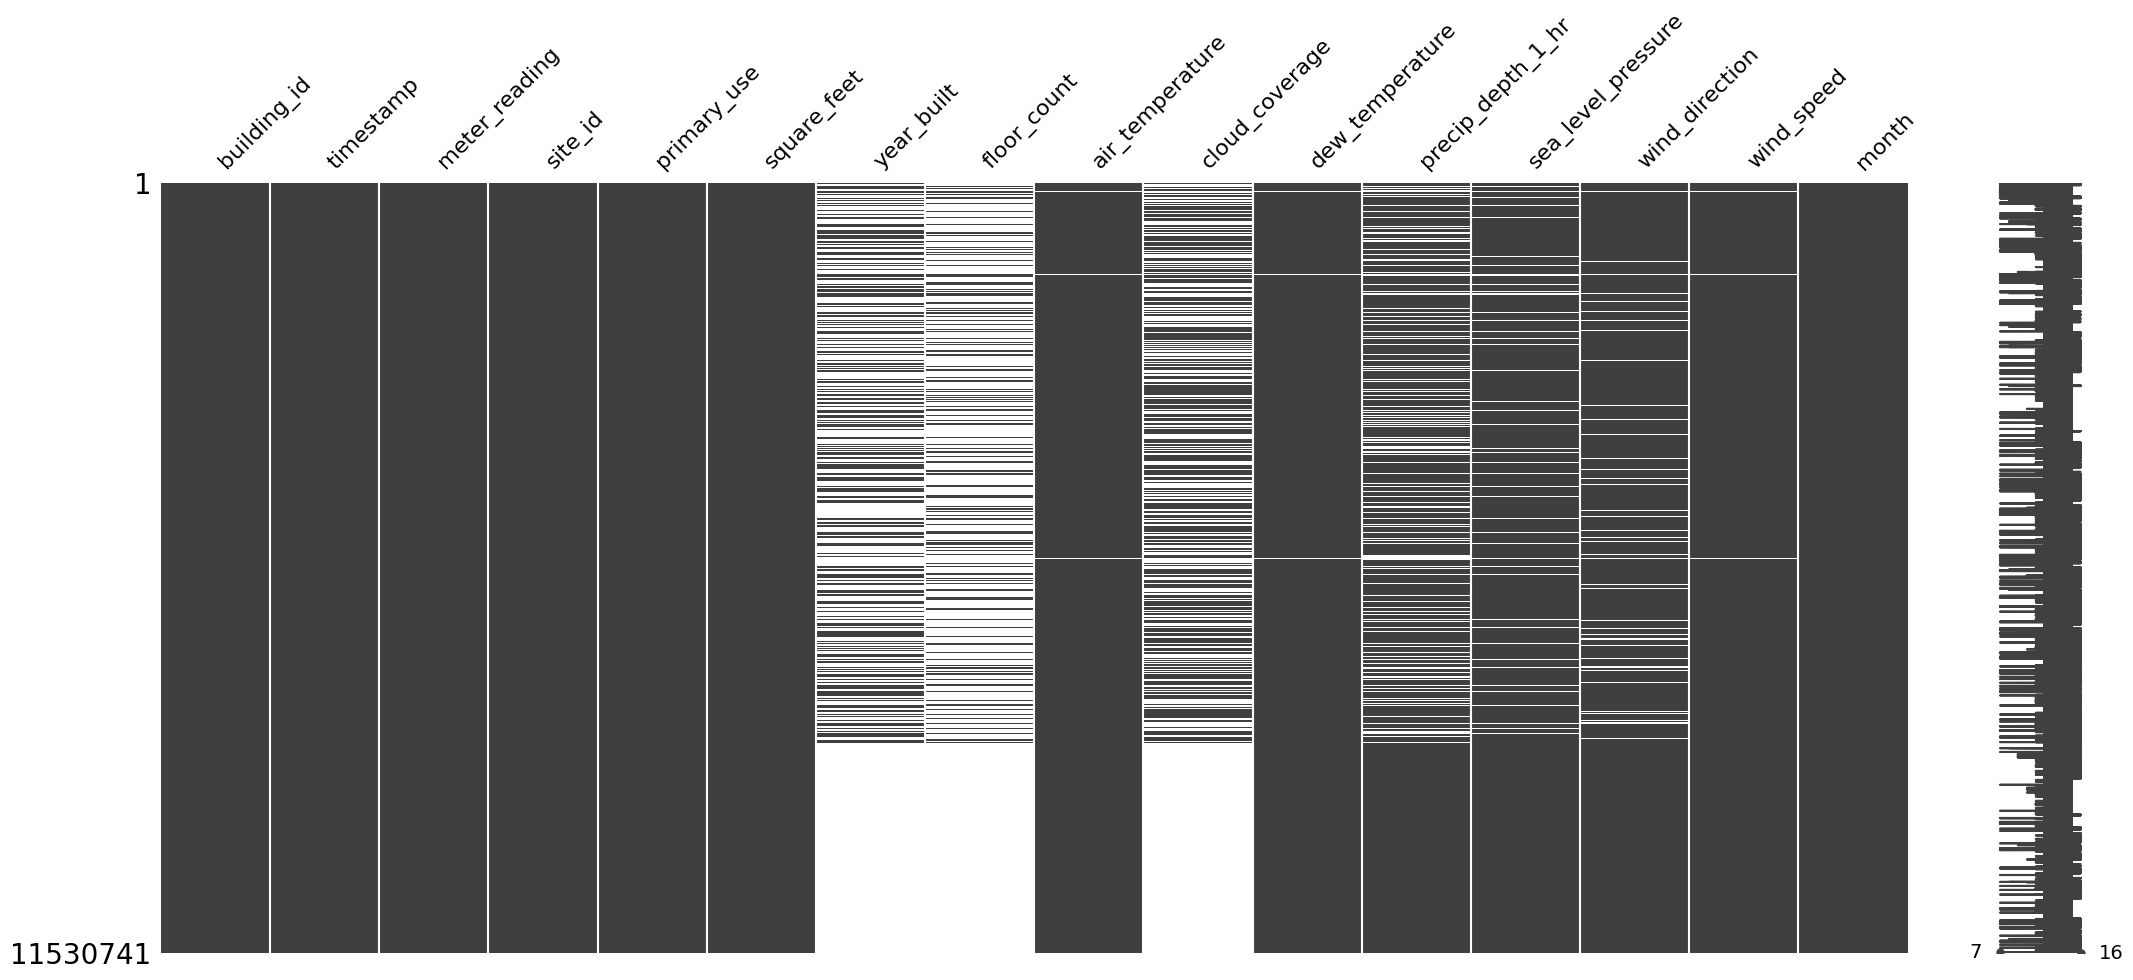

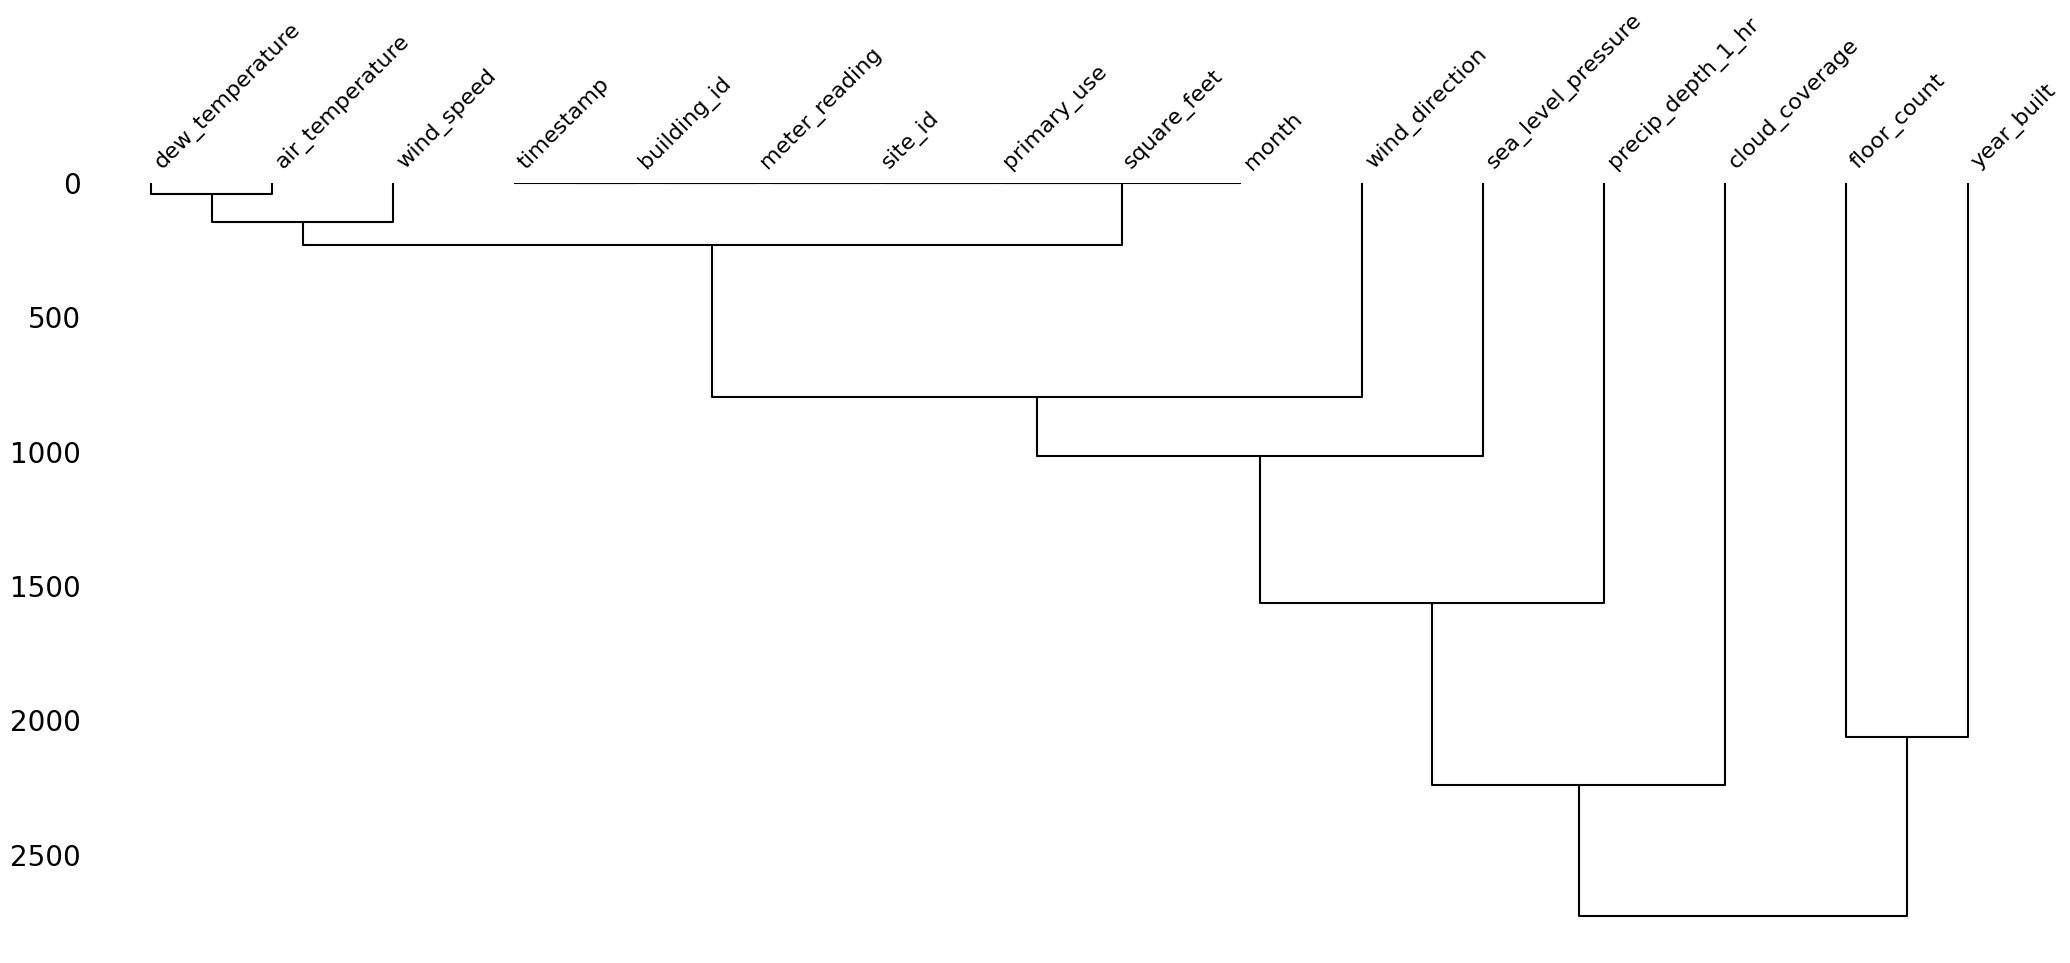

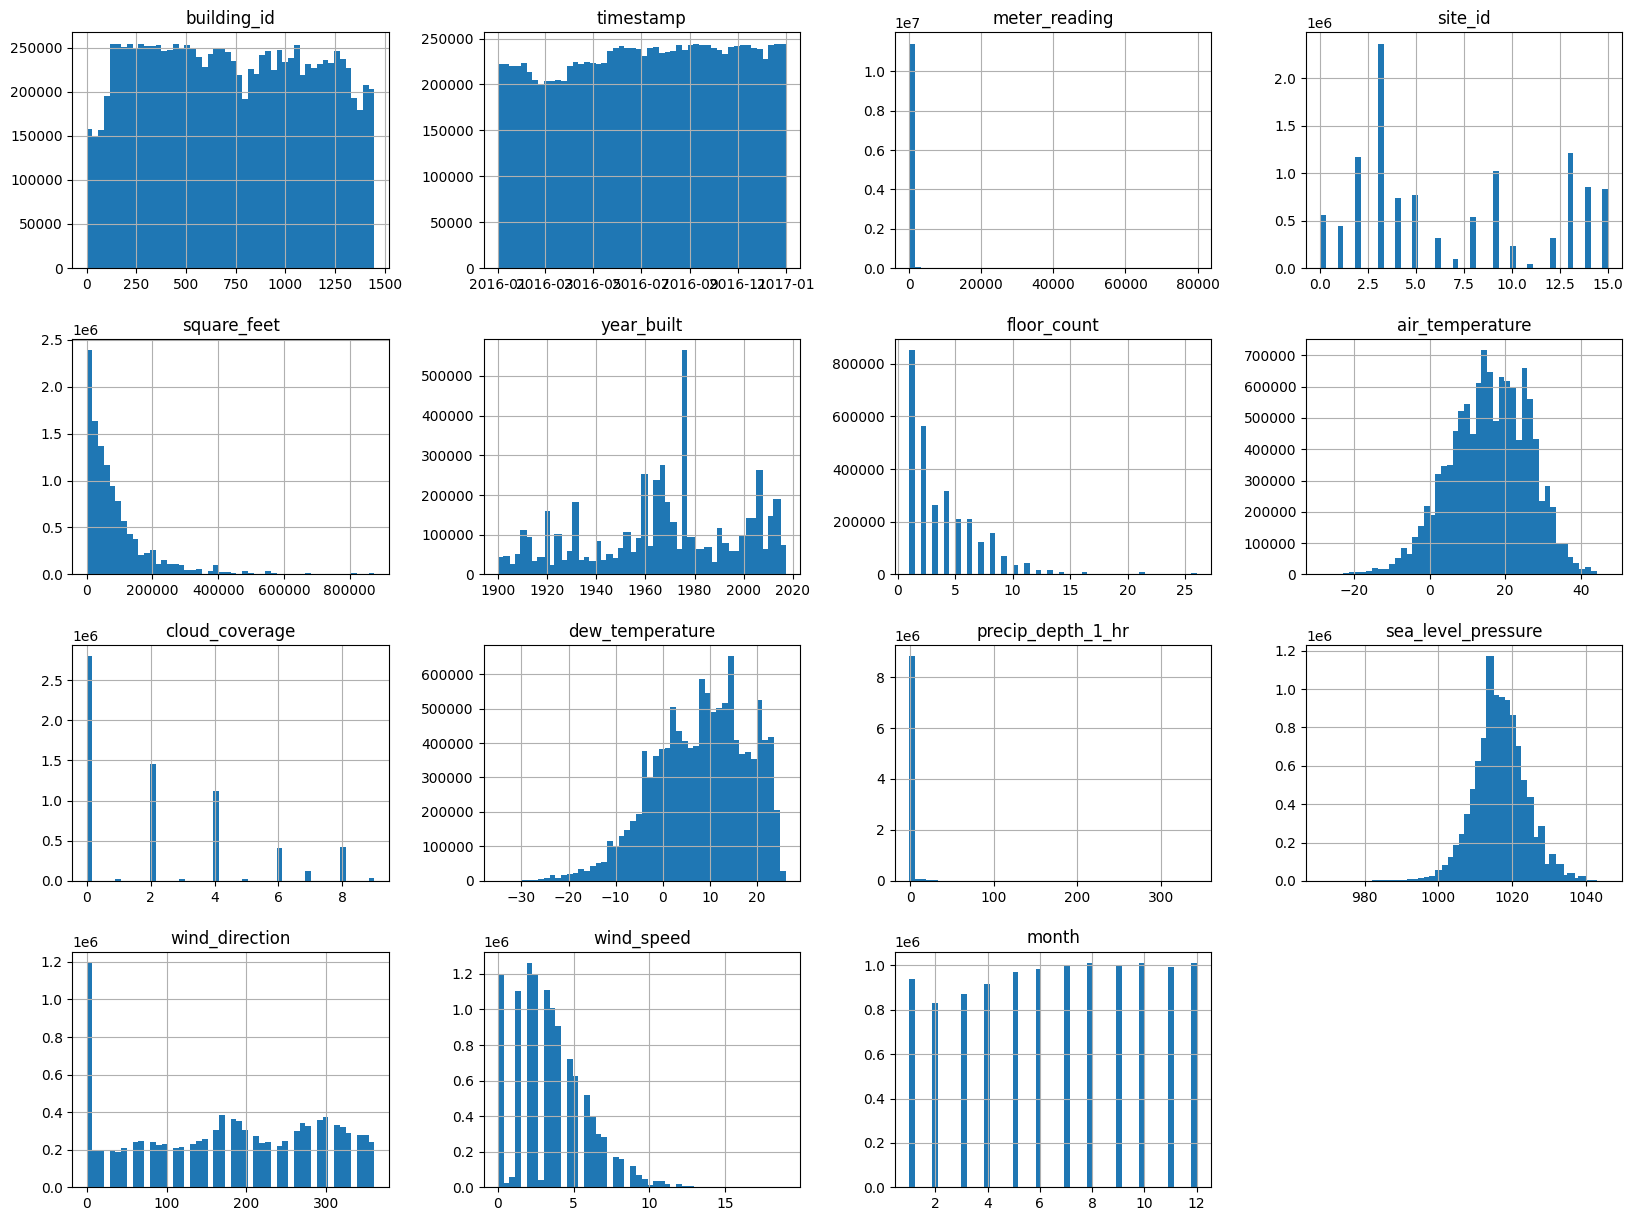

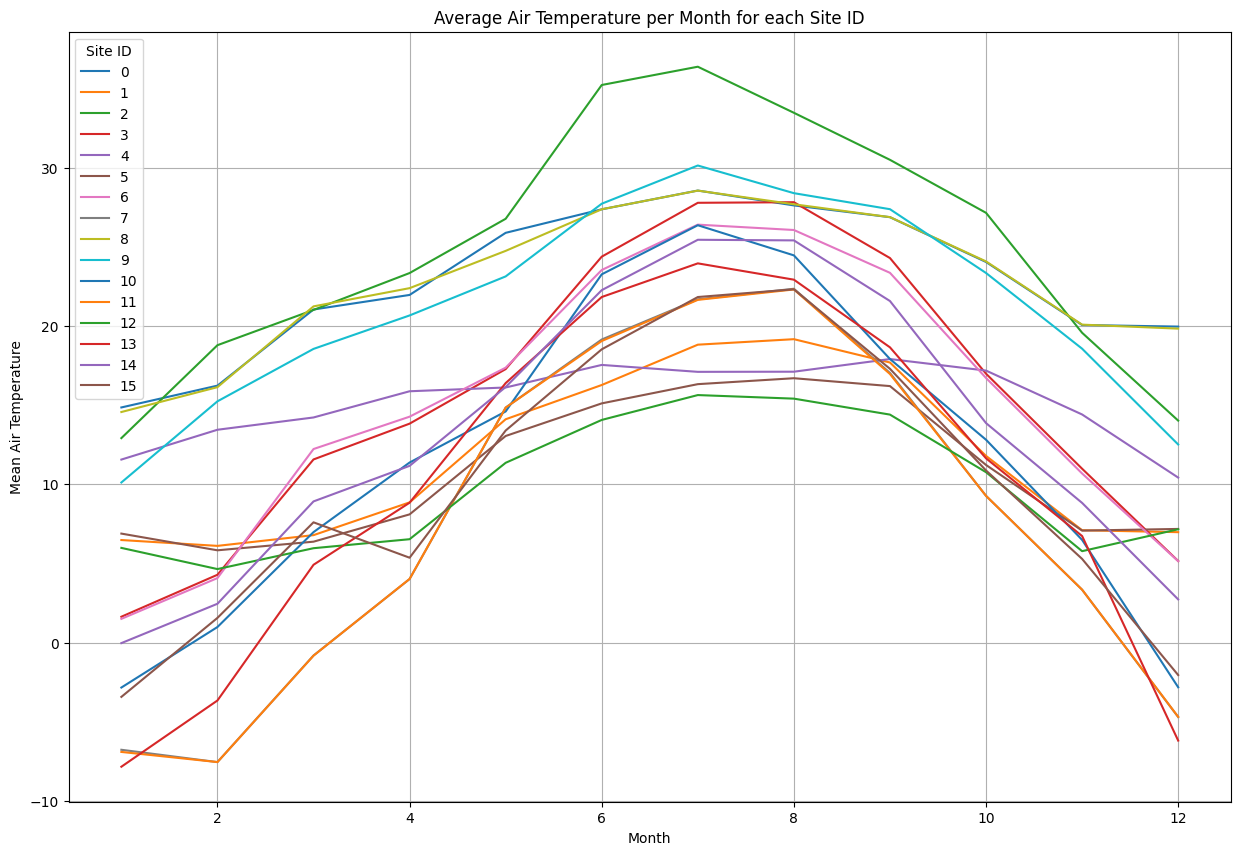

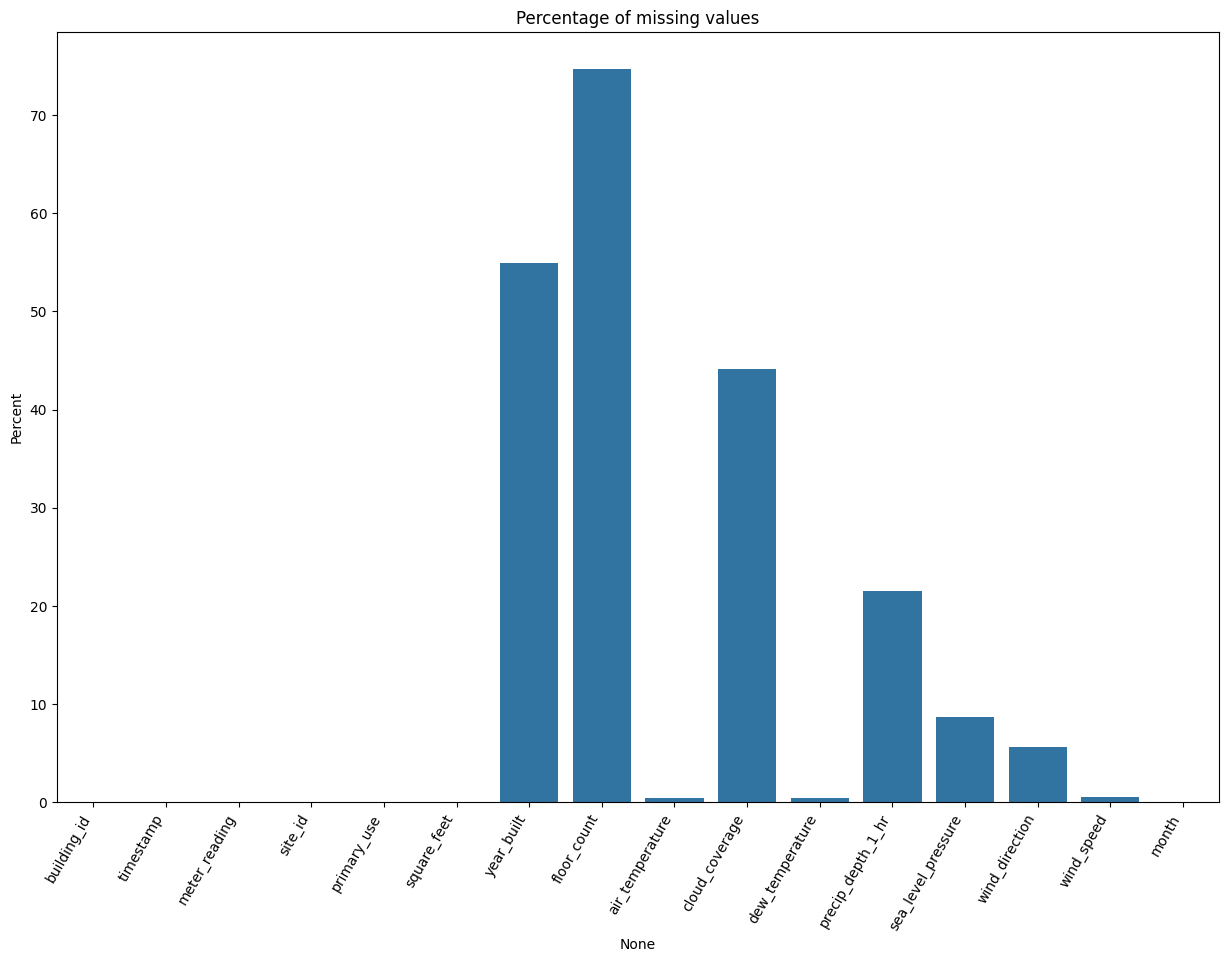

In [22]:
# Calculate the percentage of missing values in each column
missing_percentage = train.isnull().mean() * 100
print(missing_percentage)

# Plot the missing values matrix
msno.matrix(train)
plt.show()

# Plot the dendrogram of missing values
msno.dendrogram(train)
plt.show()

# Plot the distribution of columns
train.hist(bins=50, figsize=(20, 15))
plt.show()

# Plot the mean air temperature for each month for each site_id
monthly_temp = train.groupby(['site_id', 'month'])['air_temperature'].mean().unstack(level=0)
monthly_temp.plot(kind='line', figsize=(15, 10))
plt.xlabel('Month')
plt.ylabel('Mean Air Temperature')
plt.title('Average Air Temperature per Month for each Site ID')
plt.legend(title='Site ID')
plt.grid()
plt.show()

# Additional plot to demonstrate the percentage of missing values
plt.figure(figsize=(15, 10))
sns.barplot(x=missing_percentage.index, y=missing_percentage.values)
plt.xticks(rotation=60, ha='right')
plt.ylabel('Percent')
plt.title('Percentage of missing values')
plt.show()

In [23]:
# Drop columns with more than 40% missing values and timestamp and define as a new DataFrame
train_0 = train.drop(columns=['year_built', 'floor_count', 'cloud_coverage', 'timestamp'])

# Drop rows with any missing values
train_0 = train_0.dropna()

# Particular initialization of Supervised Learning
# Encode primary_use column
le = LabelEncoder()
train_0['primary_use'] = le.fit_transform(train_0['primary_use'])

# Separation of data based on the "meter_reading" column (split features and target)
X = train_0.drop(columns=['meter_reading'])
y = train_0['meter_reading']

# Split data into training and testing sets (with a test size of 30%)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

# Definition of the training process by DecisionTreeRegressor model
model = DecisionTreeRegressor(max_depth=20)
model.fit(X_train, y_train)

# Predict and calculate R-squared
y_pred = model.predict(X_test)
r2 = r2_score(y_test, y_pred)
print(f'R-squared: {r2}')

R-squared: 0.8658309430493726


In [24]:
# Fill missing values in sea_level_pressure with the average of the column
train['sea_level_pressure'] = train['sea_level_pressure'].fillna(train['sea_level_pressure'].mean())

# Fill missing values in air_temperature with the average of each site and month
train['air_temperature'] = train.groupby(['site_id', 'month'])['air_temperature'].transform(lambda x: x.fillna(x.mean()))

/usr/local/lib/python3.10/dist-packages/pandas/core/nanops.py:1487: RuntimeWarning: overflow encountered in cast
  return dtype.type(n)
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:49: RuntimeWarning: overflow encountered in reduce
  return umr_sum(a, axis, dtype, out, keepdims, initial, where)
/usr/local/lib/python3.10/dist-packages/pandas/core/nanops.py:731: RuntimeWarning: invalid value encountered in scalar divide
  the_mean = the_sum / count if count > 0 else np.nan


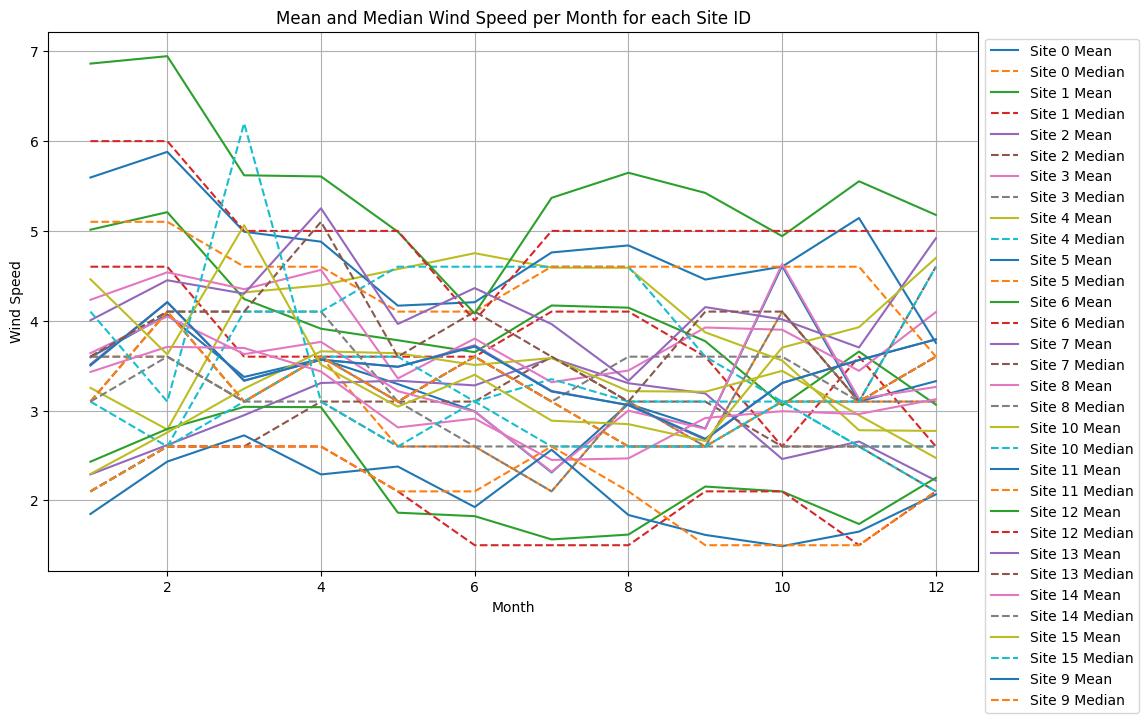

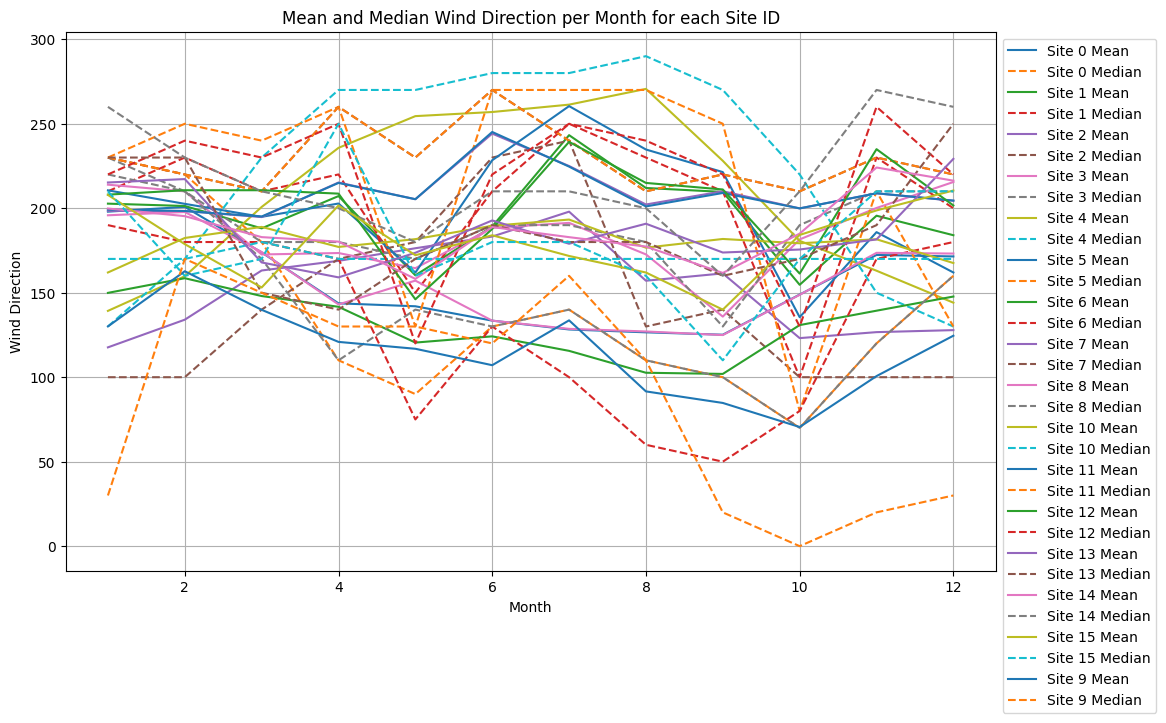

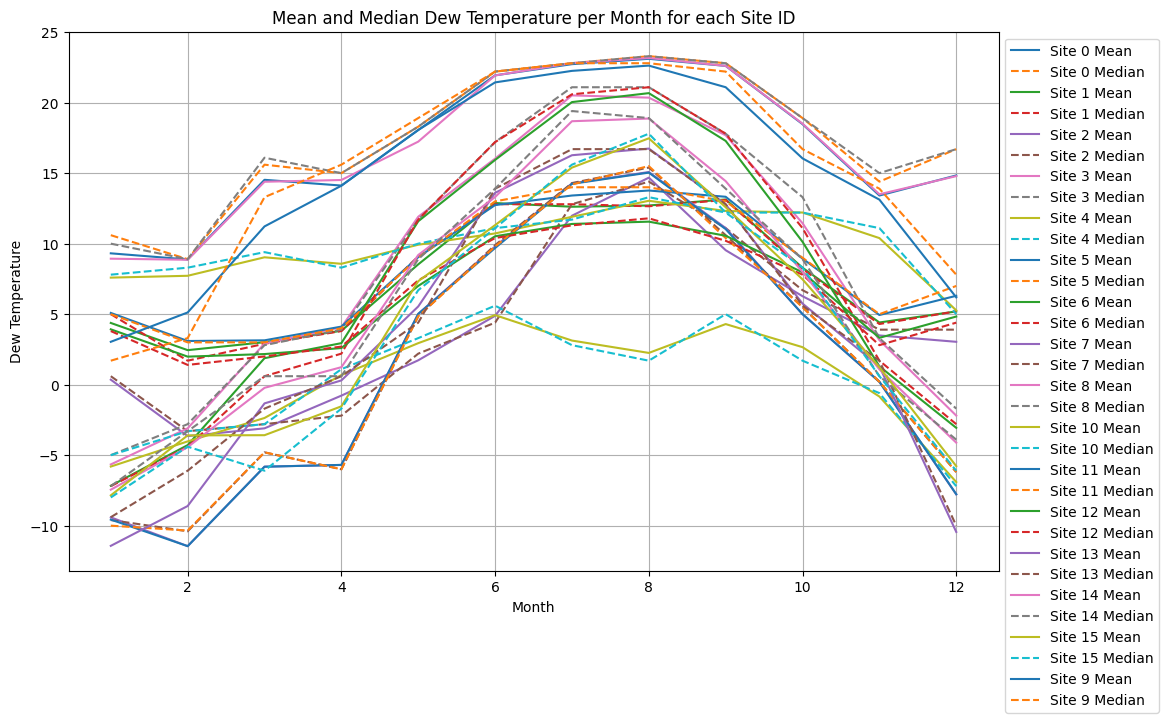

In [25]:
# Calculate the mean and median for each month and site_id for the three columns
monthly_stats = train.groupby(['site_id', 'month'])[['wind_speed', 'wind_direction', 'dew_temperature']].agg(['mean', 'median'])

# Display the current status
# Plot the mean and median for wind_speed
plt.figure(figsize=(12, 7))
for site_id in train['site_id'].unique():
    plt.plot(monthly_stats.loc[site_id, ('wind_speed', 'mean')], label=f'Site {site_id} Mean')
    plt.plot(monthly_stats.loc[site_id, ('wind_speed', 'median')], linestyle='--', label=f'Site {site_id} Median')
plt.xlabel('Month')
plt.ylabel('Wind Speed')
plt.title('Mean and Median Wind Speed per Month for each Site ID')
plt.legend(bbox_to_anchor=(1, 1))
plt.grid()
plt.show()

# Plot the mean and median for wind_direction
plt.figure(figsize=(12, 7))
for site_id in train['site_id'].unique():
    plt.plot(monthly_stats.loc[site_id, ('wind_direction', 'mean')], label=f'Site {site_id} Mean')
    plt.plot(monthly_stats.loc[site_id, ('wind_direction', 'median')], linestyle='--', label=f'Site {site_id} Median')
plt.xlabel('Month')
plt.ylabel('Wind Direction')
plt.title('Mean and Median Wind Direction per Month for each Site ID')
plt.legend(bbox_to_anchor=(1, 1))
plt.grid()
plt.show()

# Plot the mean and median for dew_temperature
plt.figure(figsize=(12, 7))
for site_id in train['site_id'].unique():
    plt.plot(monthly_stats.loc[site_id, ('dew_temperature', 'mean')], label=f'Site {site_id} Mean')
    plt.plot(monthly_stats.loc[site_id, ('dew_temperature', 'median')], linestyle='--', label=f'Site {site_id} Median')
plt.xlabel('Month')
plt.ylabel('Dew Temperature')
plt.title('Mean and Median Dew Temperature per Month for each Site ID')
plt.legend(bbox_to_anchor=(1, 1))
plt.grid()
plt.show()

In [26]:
# Fill missing values in dew_temperature and wind_speed by the average of each site and month
train['dew_temperature'] = train.groupby(['site_id', 'month'])['dew_temperature'].transform(lambda x: x.fillna(x.mean()))
train['wind_speed'] = train.groupby(['site_id', 'month'])['wind_speed'].transform(lambda x: x.fillna(x.mean()))

# Fill missing values in wind_direction by the median of each site and month
train['wind_direction'] = train.groupby(['site_id', 'month'])['wind_direction'].transform(lambda x: x.fillna(x.median()))

/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:49: RuntimeWarning: overflow encountered in reduce
  return umr_sum(a, axis, dtype, out, keepdims, initial, where)
/usr/local/lib/python3.10/dist-packages/pandas/core/nanops.py:1487: RuntimeWarning: overflow encountered in cast
  return dtype.type(n)
/usr/local/lib/python3.10/dist-packages/pandas/core/nanops.py:731: RuntimeWarning: invalid value encountered in scalar divide
  the_mean = the_sum / count if count > 0 else np.nan


In [27]:
# Sort data by site_id and timestamp
train = train.sort_values(by=['site_id', 'timestamp'])

# Interpolate missing values in cloud_coverage using linear interpolation
train['cloud_coverage'] = train['cloud_coverage'].interpolate(method='linear')

In [28]:
# Replace NaN values in precip_depth_1_hr with 0 (where cloud_coverage is 0)
train.loc[(train['cloud_coverage'] == 0) & (np.isnan(train['precip_depth_1_hr'])), 'precip_depth_1_hr'] = 0

# Calculate the percentage of missing values in precip_depth_1_hr
missing_precip = np.isnan(train['precip_depth_1_hr']).mean() * 100
print(f'Missing values in precip_depth_1_hr: {missing_precip:.2f}%')

# Fill remaining NaN values in precip_depth_1_hr with the monthly mean
train['precip_depth_1_hr'] = train.groupby(['site_id', 'month'])['precip_depth_1_hr'].transform(lambda x: x.fillna(x.mean() if not np.isnan(x.mean()) else -1))

Missing values in precip_depth_1_hr: 9.12%


/usr/local/lib/python3.10/dist-packages/pandas/core/nanops.py:1487: RuntimeWarning: overflow encountered in cast
  return dtype.type(n)
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:49: RuntimeWarning: overflow encountered in reduce
  return umr_sum(a, axis, dtype, out, keepdims, initial, where)
/usr/local/lib/python3.10/dist-packages/pandas/core/nanops.py:731: RuntimeWarning: invalid value encountered in scalar divide
  the_mean = the_sum / count if count > 0 else np.nan


In [29]:
# Make a copy of the original data frame
train_1 = train.copy()

# Remove "year_built" and "floor_count" columns
train_1 = train_1.drop(columns=['year_built', 'floor_count'])

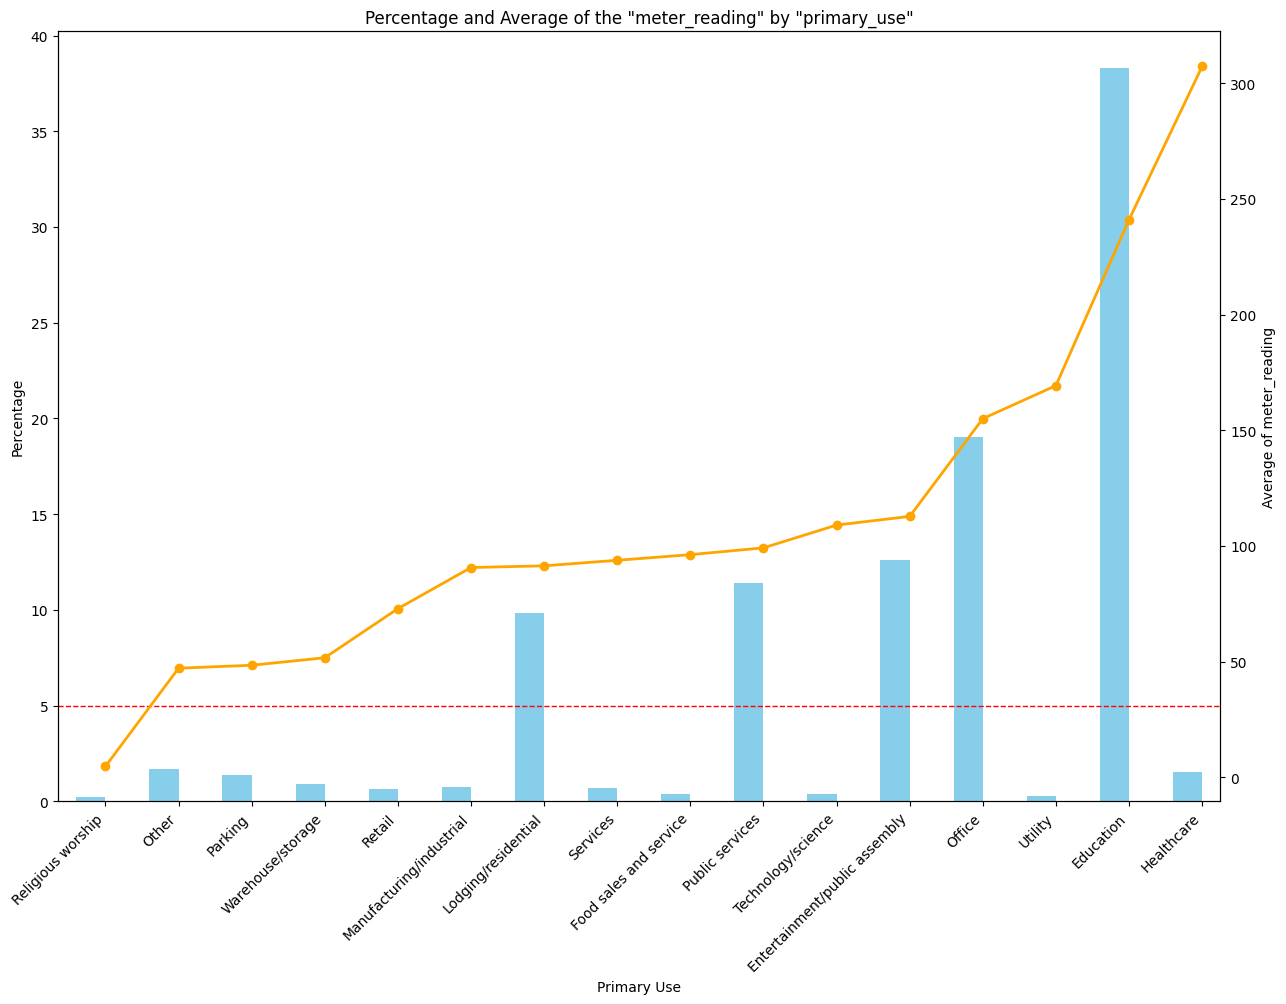

In [30]:
# Percentage of each "primary_use"
primary_use_percentage = train_1['primary_use'].value_counts(normalize=True) * 100

# Average of the "meter_reading" based on each "primary_use"
primary_use_meter_reading = train_1.groupby('primary_use')['meter_reading'].mean()

# Convert to a DataFrame for plotting
primary_use_stats = pd.DataFrame({
    'percentage': primary_use_percentage,
    'meter_reading_mean': primary_use_meter_reading
}).sort_values(by='meter_reading_mean')

# Plot configuration
fig, ax1 = plt.subplots(figsize=(15, 10))
primary_use_stats['percentage'].plot(kind='bar', ax=ax1, color='skyblue', position=1, width=0.4)
ax1.set_ylabel('Percentage')
ax1.set_xlabel('Primary Use')
ax1.set_xticklabels(primary_use_stats.index, rotation=45, ha='right')
ax1.axhline(y=5, color='r', linestyle='--', linewidth=1)

# Second y-axis for the mean meter reading
ax2 = ax1.twinx()
primary_use_stats['meter_reading_mean'].plot(kind='line', ax=ax2, color='orange', marker='o', linewidth=2)
ax2.set_ylabel('Average of meter_reading')

# Display the plot
plt.title('Percentage and Average of the "meter_reading" by "primary_use"')
plt.show()

In [31]:
# Combine similar categories
train_1['primary_use'] = train_1['primary_use'].replace(['Other', 'Utility', 'Retail', 'Parking'], 'Other')

# Encoding process on the target column
le = LabelEncoder()
train_1['primary_use'] = le.fit_transform(train_1['primary_use'])

In [32]:
# Remove month and timestamp columns
train_1 = train_1.drop(columns=['month', 'timestamp'])

# Separate target column
X = train_1.drop(columns=['meter_reading'])
y = train_1['meter_reading']

In [38]:
from sklearn.impute import SimpleImputer

# Replace infinite values with NaN
X.replace([np.inf, -np.inf], np.nan, inplace=True)

# Initialize the SimpleImputer
imputer = SimpleImputer(strategy='mean')

# Apply the method to the data
train_imputed = imputer.fit_transform(X)

# Convert to a DataFrame
train_data = pd.DataFrame(train_imputed, columns=X.columns)

In [36]:
# from sklearn.impute import KNNImputer


# # Replace infinite values with NaN
# X.replace([np.inf, -np.inf], np.nan, inplace=True)

# # Initialize the KNNImputer with the specified parameters
# imputer = KNNImputer(n_neighbors=5, weights='distance', metric='nan_euclidean', add_indicator=False)

# # Apply the imputer to the training data
# train_imputed = imputer.fit_transform(X)

# # Convert the imputed data back to a DataFrame
# train = pd.DataFrame(train_imputed, columns=train.columns)

KeyboardInterrupt: 

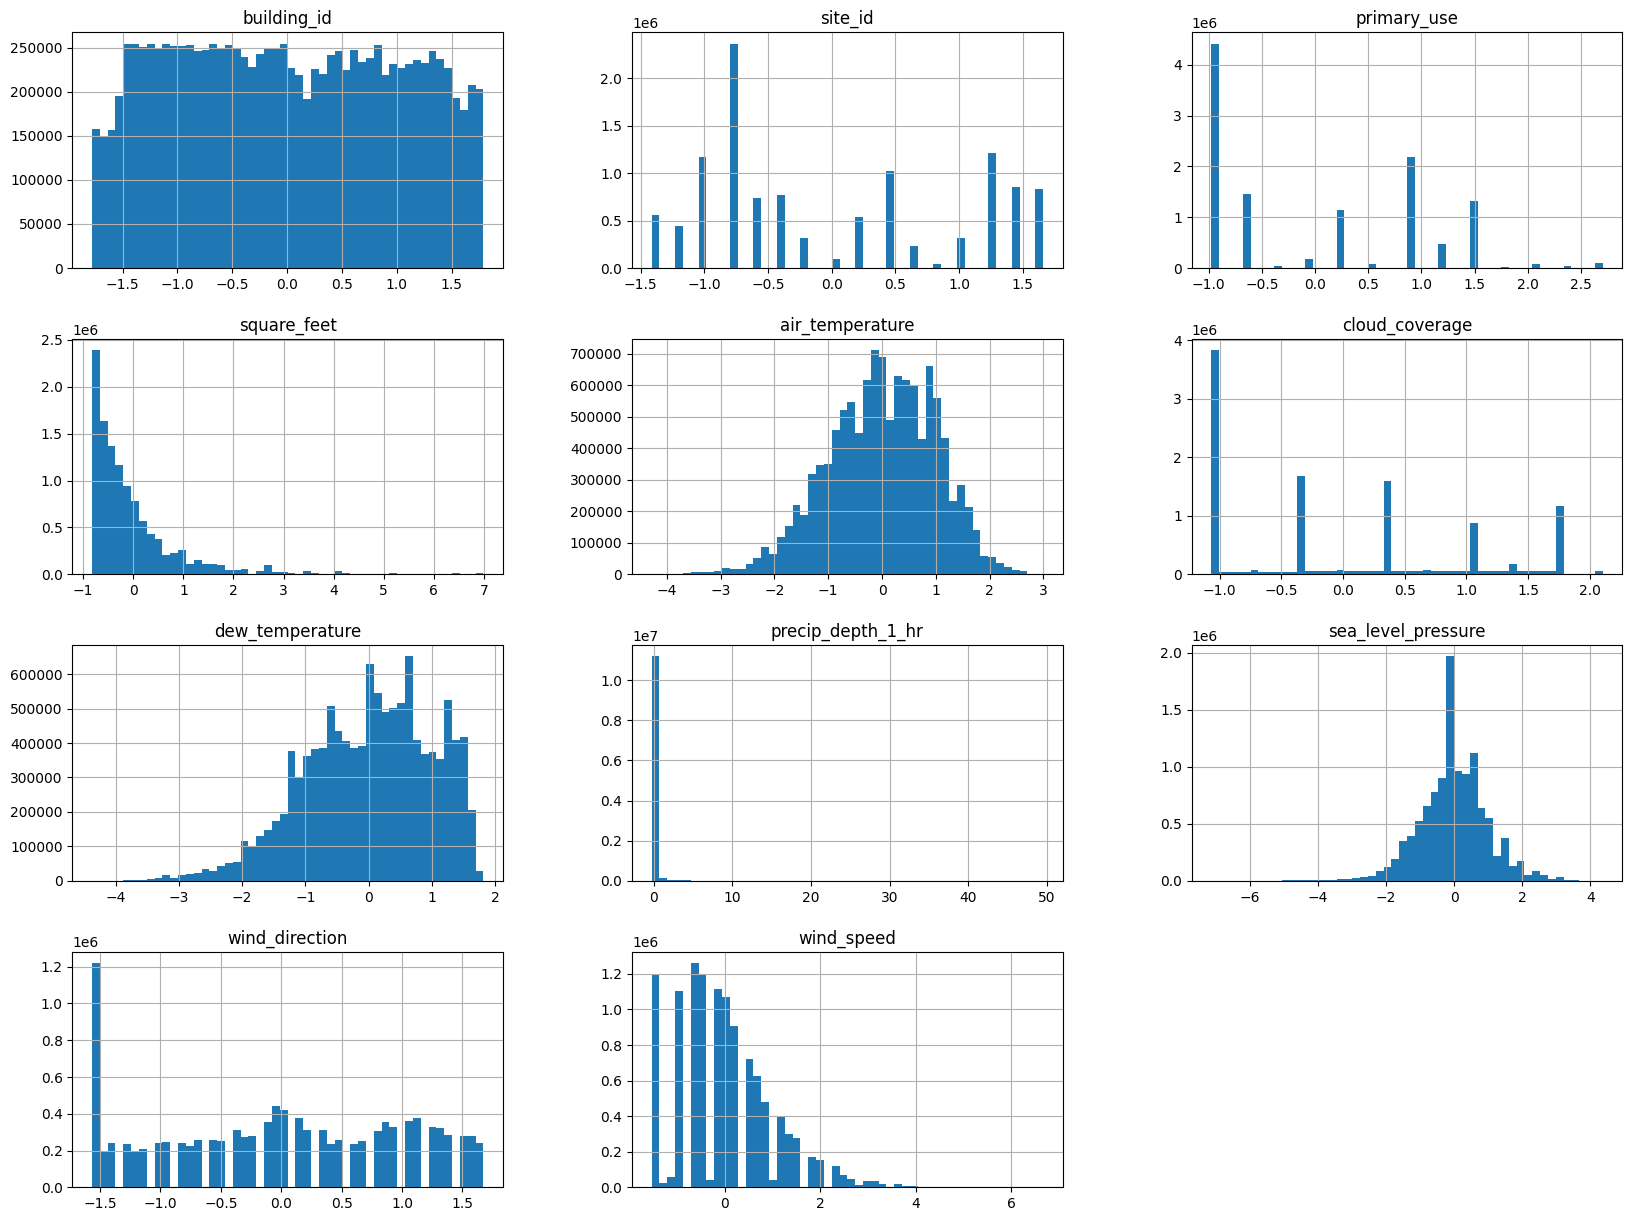

In [39]:
# Initialize the StandardScaler
scaler = StandardScaler()

# Fit and transform the training data
train_scaled = scaler.fit_transform(train_data)

# Convert the scaled data back to a DataFrame
train_df = pd.DataFrame(train_scaled, columns=train_data.columns)

# Plot the distribution of the scaled data
train_df.hist(bins=50, figsize=(20, 15))
plt.show()

In [40]:
# Separate features and target
X = train_df
y = train['meter_reading']

# Split data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

# Initialize and train the model
model = DecisionTreeRegressor(max_depth=20)
model.fit(X_train, y_train)

# Predict and calculate R-squared
y_pred = model.predict(X_test)
r2 = r2_score(y_test, y_pred)
print(f'R-squared: {r2}')

R-squared: 0.9194784654626053


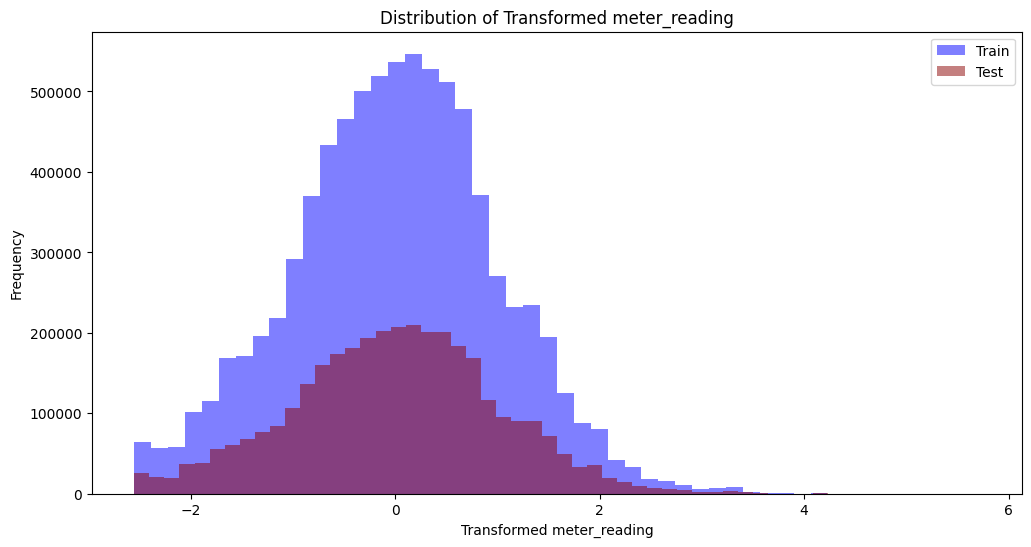

R-squared: 0.9203593168122897


In [42]:
# Initialize the PowerTransformer (based on Yeo-Johnson transformation method)
pt = PowerTransformer(method='yeo-johnson')

# Fit and transform the target variable
y_train_transformed = pt.fit_transform(y_train.values.reshape(-1, 1))
y_test_transformed = pt.transform(y_test.values.reshape(-1, 1))

# Plot the distribution of the transformed target variable
plt.figure(figsize=(12, 6))
plt.hist(y_train_transformed, bins=50, alpha=0.5, label='Train', color='blue')
plt.hist(y_test_transformed, bins=50, alpha=0.5, label='Test', color='darkred')
plt.xlabel('Transformed meter_reading')
plt.ylabel('Frequency')
plt.legend()
plt.title('Distribution of Transformed meter_reading')
plt.show()

# Train the model with the transformed target variable
model = DecisionTreeRegressor(max_depth=20)
model.fit(X_train, y_train_transformed.ravel())

# Predict and calculate R-squared
y_pred_transformed = model.predict(X_test)
y_pred = pt.inverse_transform(y_pred_transformed.reshape(-1, 1))
r2 = r2_score(y_test, y_pred)
print(f'R-squared: {r2}')